In [1]:
import scanpy as sc
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter, defaultdict
from scipy.sparse import csr_matrix
from scipy import sparse
import itertools as it
import anndata as ad
from utils import *

In [4]:
FILE = "datasets/10XGenomics/Targeted_SC3v3_Human_Glioblastoma_Neuroscience_filtered_feature_bc_matrix.h5"
# FILE = "datasets/10XGenomics/Human_PBMCs_Next_GEM_Flex_GEM-X_Flex_Comparison_count_filtered_feature_bc_matrix.h5"

In [14]:
# adata = sc.read_10x_h5(FILE)
adata = sc.read_mtx("E-GEOD-167266.aggregated_filtered_counts.mtx")
X = adata.X.todense()
X.shape

(14690, 48228)

In [12]:
c = Counter(np.array(X).flatten())

In [13]:
sum(c[i] for i in np.array(X).flatten() if i > 488)

2172

In [8]:
np.count_nonzero(X)

1850701

In [9]:
10384 / 1850701

0.005610846916924993

In [4]:
X[:10, :10]

matrix([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 3., 2., 4., 1., 0., 2., 5., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 3.],
        [0., 0., 0., 0., 0., 0., 0., 2., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [5]:
adata.to_df()


,0,1,2,3,4,5,6,7,8,9,...,48218,48219,48220,48221,48222,48223,48224,48225,48226,48227
0,0.0,0.0,0.00000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,3.0,2.00000,4.0,1.0,0.0,2.0,5.0,0.0,0.0,...,4.0,2.0,1.0,1.0,2.0,0.0,0.000000,0.0,1.0,3.0
4,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14685,0.0,0.0,0.02439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.088235,0.0,0.0,0.0
14686,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
14687,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
14688,0.0,0.0,0.00000,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [4]:
B = lambda i: len(bin(i)) - 2
def cell(X, i):
    return np.array(X[i, :]).flatten()

In [5]:
def write_bytes(handle, bits, bytes=4):
    handle.write(int(bits[::-1], 2).to_bytes(bytes, 'little'))
    return bytes * 4

def write_int(handle, value, bytes=4):
    handle.write(value.to_bytes(bytes, 'little'))
    return bytes * 4

def write_array(handle, array):
    if not array:
        write_int(handle, 0)
        return 32
    bits = len(bin(int(max(array)))) - 2
    write_int(handle, len(array))
    write_int(handle, bits)

    # print(len(array), bits, (len(array) * 23) - (len(array) * bits + 2 * 32 * 8))
    curr_str = ""
    for elem in array:
        s = bin(int(elem))[2:].zfill(bits)
        for char in s:
            curr_str += char
            if len(curr_str) == 32:
                write_bytes(handle, curr_str)
                curr_str = ""
    if curr_str:
        write_bytes(handle, curr_str)

    return len(array) * bits + 2 * 32 * 8

def write_arrays(handle, arrays):
    total = write_int(handle, len(arrays))
    for array in arrays:
        total += write_array(handle, array)
    return total

In [18]:
B = lambda i: len(bin(int(i))) - 2

def chop(bins, chop, testdrive=True):
    n = 0
    out = []
    curr = []
    chopping = False
    for i in bins:
        if (i >= chop and not chopping) or (i < chop and chopping):
            if curr:
                n += len(curr) * max(curr) + 2 * 32 * 8 # add space for writing bitsize and length of array
                out.append(len(curr))
                curr = []
                chopping = not chopping
        curr.append(i)
    if curr:
        out.append(len(curr))
        n += len(curr) * max(curr) + 2 * 32 * 8 # add space for writing bitsize and length of array
    return n if testdrive else out

def unchop(chopped):
    return [i for j in chopped for i in j]

def do_chop(array, chops):
    out = []
    i = 0
    for k in chops:
        curr = []
        for _ in range(k):
            curr.append(array[i])
            i += 1
        out.append(curr)
    return out

def optimal_chop(array):
    bins = list(map(B, array))
    m = max(bins) + 1
    last_chop = chop(bins, m)
    while True:
        test_chop = chop(bins, m - 1)
        if test_chop < last_chop:
            last_chop = test_chop
            m -= 1
        else:
            break
    
    return do_chop(array, chop(bins, m, testdrive=False))

In [21]:
def flat_to_square(val, ncols):
    return (val // ncols, val % ncols)

def squarify_indices(arr, shape):
    R, C = shape
    coldiffs = []
    rowchanges = []
    current_col = 0
    current_row = 0
    # print(arr[:100])
    for element in arr:#[:100]:
        row, col = flat_to_square(element, C)
        # print([row, col], end=' ')
        if row > current_row:
            coldiffs.append(col)
            rowchanges.append(row - current_row)
        else:
            coldiffs.append(col - current_col)
            rowchanges.append(0)
        current_col, current_row = col, row
    # print(coldiffs[:100], rowchanges[:100])
    # print(R, C)
    # input()
    return coldiffs, rowchanges

def consecutivize(X, handle, depth=1):
    ncells = X.shape[0]
    cells = []
    for i in tqdm.trange(ncells):
        cells.append(cell(X, i))

    c = Counter(np.array(cells).flatten())
    del c[0]

    N = np.array(X).flatten().shape[0]
    O = c[1]
    
    i = min(c)
    body = []
    while i in c:
        body.append(c[i])
        i += 1
        if i == 0:
            i += 1
    K = i - 1
    
    T = 0
    T1 = []
    T2 = []
    M = int(max(c))
    for j in tqdm.trange(int(i), M + 1):
        if j not in c:
            continue
        T += 1
        T1.append(j)
        T2.append(c[j])

    if T2:
        S = max(T2)
    Xf = np.array(cells).flatten()
    d = defaultdict(list)
    for a, b in tqdm.tqdm(enumerate(Xf)):
        d[b].append(a)

    e = {}
    for k, v in tqdm.tqdm(d.items()):
        if v:
            diffs = [v[0]] + [v[i + 1] - v[i] for i in range(len(v) - 1)]
            if k < 10:
                e[k] = optimal_chop(diffs)
            else:
                e[k] = diffs
            # e[k] = squarify_indices(v, X.shape)
    e = {k: v for k, v in e.items() if k in range(1, 101)}

    R = []
    for i in tqdm.trange(101, M + 1):
        if i in d:
            for j in d[i]:
                R.append(j)
    
    total = 0
    total += write_int(handle, X.shape[1])
    for i in range(1, 10):
        if i in e:
            total += write_arrays(handle, e[i])
    for i in range(10, 101):
        if i in e:
            total += write_array(handle, e[i])
    total += write_array(handle, R)
    total += write_array(handle, body)
    total += write_array(handle, T1)
    total += write_array(handle, T2)

    return d, e, R, total
    # return total
# d, e, R, total = consecutivize(X, open("f3_0.conq", "wb"))
# total
# sizes = {}
# for i in tqdm.trange(3, 127):
#     adata_cut = ad.AnnData(reclassify(sc.read_10x_h5(FILE).X.todense(), i))
#     X = adata_cut.X
#     d, e, R, total = consecutivize(X, open("f2_7.conq", "wb"))
#     # total
#     sizes[i] = total
# d, e, R, total = consecutivize(X, open("Human_PBMCs_Next_GEM_Flex_GEM-X_Flex_Comparison_count_filtered_feature_bc_matrix.conq", "wb"))
# total

In [8]:
total

891038391

In [35]:
sizes

{3: 12104423,
 4: 12118692,
 5: 12134139,
 6: 12151637,
 7: 12172489,
 8: 12191549,
 9: 12209856,
 10: 12226891,
 11: 12248095,
 12: 12265458,
 13: 12289570,
 14: 12305494,
 15: 12327607,
 16: 12351563,
 17: 12372126,
 18: 12392815,
 19: 12415016,
 20: 12430919,
 21: 12454432,
 22: 12472181,
 23: 12489351,
 24: 12498431,
 25: 12520157,
 26: 12529006,
 27: 12555459,
 28: 12572128,
 29: 12586165,
 30: 12600916,
 31: 12617937,
 32: 12635903,
 33: 12655812,
 34: 12679103,
 35: 12703729,
 36: 12703729,
 37: 12729386,
 38: 12753135,
 39: 12753135,
 40: 12783518,
 41: 12815865,
 42: 12815865,
 43: 12852892,
 44: 12852892,
 45: 12886004,
 46: 12886004,
 47: 12886004,
 48: 12936076,
 49: 12936076,
 50: 12979656,
 51: 12979656,
 52: 12979656,
 53: 13016957,
 54: 13016957,
 55: 13016957,
 56: 13058038,
 57: 13058038,
 58: 13058038,
 59: 13108937,
 60: 13108937,
 61: 13108937,
 62: 13108937,
 63: 13168883,
 64: 13168883,
 65: 13168883,
 66: 13168883,
 67: 13168883,
 68: 13219422,
 69: 13219422,
 7

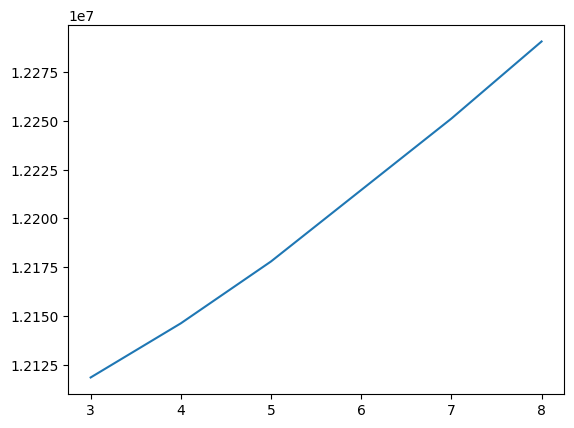

In [15]:
plt.plot(sizes.keys(), sizes.values())

In [16]:
def read_bytes(handle, bytes=4):
    byte_data = handle.read(bytes)
    value = int.from_bytes(byte_data, 'little')
    return bin(value)[2:].zfill(32)[::-1]

def read_int(handle, bytes=4):
    return int.from_bytes(handle.read(bytes), 'little')

def read_array(handle):
    array_length = read_int(handle)
    bits = read_int(handle)
    
    array = []
    curr_str = ""
    remaining_bits = array_length * bits
    
    while remaining_bits > 0:
        chunk = read_bytes(handle)
        if chunk is None:
            break
        curr_str += chunk
        
        while len(curr_str) >= bits and len(array) < array_length:
            element_bits = curr_str[:bits]
            curr_str = curr_str[bits:]
            array.append(int(element_bits, 2))
            remaining_bits -= bits

    return array

def read_arrays(handle):
    count = read_int(handle)
    out = []
    for _ in range(count):
        out.append(read_array(handle))
    return out

In [22]:
def conq_to_csr(handle, depth=1):
    ncols = read_int(handle)
    e = {}
    for i in range(1, 10):
        e[i] = unchop(read_arrays(handle))
    for i in range(10, 101):
        e[i] = read_array(handle)
    R = read_array(handle)
    body = read_array(handle)
    T1 = read_array(handle)
    T2 = read_array(handle)

    rows = []
    cols = []
    data = []

    for k, v in e.items():
        c = 0
        row = 0
        col = 0
        for i in v:
            c += i
            data.append(k)
            row, col = flat_to_square(c, ncols)
            rows.append(row)
            cols.append(col)
        # for i, j in zip(*v):
        #     if j:
        #         row += 1
        #         col = 0
        #     col += i
        #     data.append(k)
        #     rows.append(row)
        #     cols.append(col)

    i = 0
    for v, n in enumerate(body[100:], start=101):
        for _ in range(n):
            row, col = flat_to_square(R[i], ncols)
            data.append(v)
            rows.append(row)
            cols.append(col)
            i += 1

    for n, m in zip(T1, T2):
        for _ in range(m):
            row, col = flat_to_square(R[i], ncols)
            data.append(n)
            rows.append(row)
            cols.append(col)
            i += 1        
    
    return csr_matrix((data, (rows, cols)))

import time
t = time.time()
a = conq_to_csr(open("f3_0.conq", "rb"), depth=0)
a, time.time() - t

IndexError: list index out of range

In [23]:
time.time() - t

55.25150799751282

In [11]:
b = csr_matrix(X)
b

<5697x1186 sparse matrix of type '<class 'numpy.float32'>'
	with 1850701 stored elements in Compressed Sparse Row format>

In [12]:
a != b

<5697x1186 sparse matrix of type '<class 'numpy.bool_'>'
	with 0 stored elements in Compressed Sparse Row format>

In [13]:
sum(1 for i in e[1] if i >= 128)

TypeError: '>=' not supported between instances of 'list' and 'int'

In [ ]:
B = lambda i: len(bin(int(i))) - 2
bins = list(map(B, e[2]))

In [ ]:
max(bins)

In [ ]:
count_size(bins, 5)

In [1]:
from utils import *

In [11]:
adata_cut = ad.AnnData(reclassify(sc.read_10x_h5(FILE).X.todense(), 7))
X = adata_cut.X

/Users/simonchervenak/Documents/GitHub/CoNQuiStAdoRES/conq/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/simonchervenak/Documents/GitHub/CoNQuiStAdoRES/conq/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [16]:
d, e, R, total = consecutivize(X, open("f1_7.conq", "wb"))
total

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5697/5697 [00:00<00:00, 281262.65it/s]
0it [00:00, ?it/s]


UnboundLocalError: cannot access local variable 'd' where it is not associated with a value